In [1]:
!gdown 198uCuLf26DkECPvHS8GaDM7TD8sQ9RLh
!gdown 1OtHiSNb34oRptjsl-CohoRCGISRKVLaq

Downloading...
From: https://drive.google.com/uc?id=198uCuLf26DkECPvHS8GaDM7TD8sQ9RLh
To: /content/labels-20250212T103318Z-001.zip
100% 3.63M/3.63M [00:00<00:00, 30.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1OtHiSNb34oRptjsl-CohoRCGISRKVLaq
From (redirected): https://drive.google.com/uc?id=1OtHiSNb34oRptjsl-CohoRCGISRKVLaq&confirm=t&uuid=52f53fbd-0a18-4621-b8ab-793f4c02d399
To: /content/image_chips_native-20250212T103727Z-001.zip
100% 891M/891M [00:15<00:00, 57.0MB/s]


In [2]:
!unzip -q /content/image_chips_native-20250212T103727Z-001.zip
!unzip -q /content/labels-20250212T103318Z-001.zip

In [4]:
# Import required libraries
import os
import shutil
import random
import numpy as np
import pandas as pd
from PIL import Image,ImageDraw
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Data Exploration and Understanding

## 1. Dataset statistics

### a. How many instances of solar panels are present in the dataset?

In [5]:
img_dir = "/content/image_chips_native/"
label_dir = "/content/labels/labels_native/"

solar_panel_count = 0

for file in sorted(os.listdir(label_dir)):
  with open(label_dir+file,"r") as f:
    solar_panel_count += len(f.read().splitlines())

print(f"The Total number of instances present in the dataset are: {solar_panel_count}")

The Total number of instances present in the dataset are: 29625


### b. Compute and show the value counts of labels per image. E.g., X images have 0 labels, Y images have 1 label, … and so on.

The count of labels per image:
 {1: 81, 2: 167, 3: 221, 4: 218, 5: 217, 6: 189, 7: 170, 8: 184, 9: 169, 10: 121, 11: 97, 12: 84, 13: 69, 14: 49, 15: 46, 16: 41, 17: 36, 18: 25, 19: 29, 20: 14, 21: 4, 22: 1, 23: 4, 24: 2, 25: 4, 26: 3, 27: 5, 28: 5, 29: 15, 30: 20, 31: 8, 32: 7, 33: 13, 34: 19, 35: 10, 36: 6, 37: 17, 38: 13, 39: 6, 40: 9, 41: 10, 42: 12, 43: 11, 44: 4, 45: 2, 46: 5, 47: 9, 48: 3, 49: 5, 50: 6, 51: 9, 52: 16, 53: 4, 54: 6, 55: 1, 56: 1, 58: 3, 59: 2, 60: 2, 61: 1, 62: 6, 63: 3, 64: 1, 65: 3, 66: 4, 67: 1, 71: 1, 72: 1, 73: 1, 74: 5, 75: 1, 76: 2, 77: 2, 78: 1}


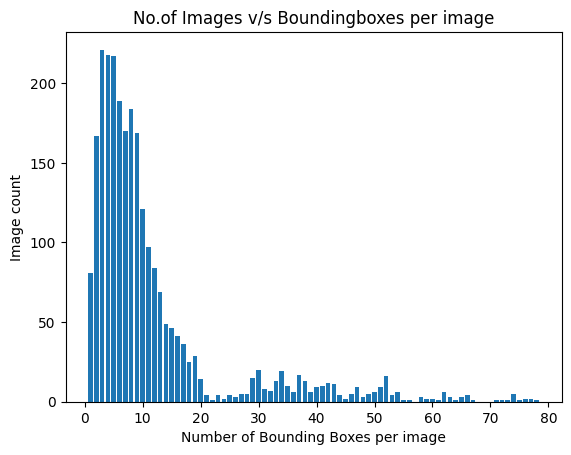

In [23]:
import numpy as np
import pandas as pd

labels_to_images = {}

for file in sorted(os.listdir(label_dir)):
  with open(label_dir+file,"r") as f:
    boxes = f.read().splitlines()
    labels_to_images[len(boxes)] = labels_to_images.get(len(boxes),0) + 1

sorted_dict = {}
for key in sorted(labels_to_images.keys()):
  sorted_dict[key] = labels_to_images[key]
print("The count of labels per image:\n",sorted_dict)
df = pd.DataFrame(sorted_dict,index=["Count"]).T
plt.bar(df.index,df["Count"])
plt.title("No.of Images v/s Boundingboxes per image")
plt.xlabel("Number of Bounding Boxes per image")
plt.ylabel("Image count")
plt.show()

In [71]:
df = pd.DataFrame(sorted_dict.items(), columns=["BBoxes per Image", "Number of Images"])

# Hide index when displaying in Jupyter Notebook / Google Colab
df.style.hide(axis="index")
df.to_csv("bboxes_per_image_count.csv")
df.head(10)

,BBoxes per Image,Number of Images
0,1,81
1,2,167
2,3,221
3,4,218
4,5,217
5,6,189
6,7,170
7,8,184
8,9,169
9,10,121


## 2. Calculate the statistics of the area of solar panels in meters (Read label readme carefully for this question)



### a. What method was used to compute the area (in meters) for a single instance?

In [9]:
# We can follow the below steps to find the area
# 1. Since the coordinates are in yolo format convert to xyxy format
# 2. Since the coordinates are normalized multiply the coordinates by img size

sample_label_path = "/content/labels/labels_native/solarpanels_native_1__x0_0_y0_7119_dxdy_416.txt"
def calculate_image_area(label_path):

  # get single instance from the file
  single_instance = open(label_path,"r").read().splitlines()[0].split(" ")
  img_width,img_height = 416,416
  x,y,w,h = float(single_instance[1]),float(single_instance[2]),float(single_instance[3]),float(single_instance[4])
  x1 = (x - w/2) * img_width
  y1 = (y - h/2) * img_height
  x2 = (x + w/2) * img_width
  y2 = (y + h/2) * img_height

  pixel_area = (x2-x1)*(y2-y1)
  # Since its given that for native the resolution is 31cm
  area_in_meters = pixel_area * (0.31)**2

  print(f"The area of an instance is: {round(area_in_meters,3)}")

calculate_image_area(sample_label_path)

The area of an instance is: 53.047


### b. What is the mean area and standard deviation?

In [10]:
def calculate_area(x,y,w,h):
  img_width,img_height = 416,416
  x1 = (x - w/2) * img_width
  y1 = (y - h/2) * img_height
  x2 = (x + w/2) * img_width
  y2 = (y + h/2) * img_height

  pixel_area = (x2-x1)*(y2-y1)
  area = pixel_area * (0.31)**2
  return area


areas = []

for file in sorted(os.listdir(label_dir)):

  with open(label_dir+file,"r") as f:
    boxes = f.read().splitlines()
    for box in boxes:
      x,y,w,h = box.split(" ")[1:]
      x,y,w,h = float(x),float(y),float(w),float(h)
      areas.append(calculate_area(x,y,w,h))

print(f"The mean area is : {np.mean(np.array(areas))}")
print(f"The standard deviation is : {np.std(np.array(areas))}")

The mean area is : 191.51782786497895
The standard deviation is : 630.7003355500087


### c. Plot the histogram of areas. What do you observe?

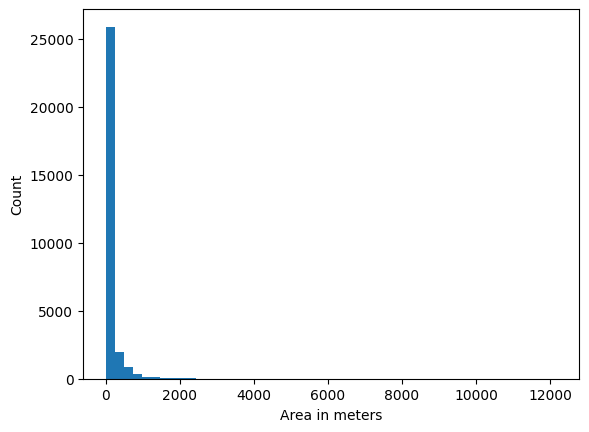

In [11]:
plt.hist(areas,bins=50)
plt.xlabel("Area in meters")
plt.ylabel("Count")
plt.show()

In [19]:
np.percentile(np.array(areas),q=90)

306.8472999999999

#### Based on the histogram plots and percentile calculation, we can clearly observe that of all the instances in the dataset, about 90% of the bounding boxes have an area less than **306 m<sup>2</sup>**
